# MNISTによるWGAN-gpのテスト

In [1]:
import os, glob, copy, time, math
visible_devices = [3]
os.environ['CUDA_VISIBLE_DEVICES'] = ','.join([str(i) for i in visible_devices])

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
from torchvision import datasets
import torchvision.transforms as transforms
from pytorch_memlab import MemReporter
from multiprocessing import Pool, cpu_count
from attrdict import AttrDict
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

# カレントディレクトリをリポジトリ直下にして自家製モジュールをimport
while os.getcwd().split('/')[-1] != 'schwbert': os.chdir('..')
print('current dir:', os.getcwd())
from utils import Timer, show_model, count_params
from modules.multi_gpu import MultiGPUWrapper

core_num = 20
print(f"{core_num}/{cpu_count()} cpus are available.")

current dir: /root/schwbert
20/32 cpus are available.


In [2]:
data_dir = "../datasets/mnist"

In [3]:
config = AttrDict({
    'batch_size': 10000,
    'img_size': 28,
    'lr': 0.0002,
    'b1': 0.5,
    'b2': 0.999,
    'latent_dim': 100,
    'dtt': 5,
    'gtt': 1,
    'gp_lambda': 10,
})

config.img_shape = (1, config.img_size, config.img_size)

## データロード

In [4]:
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        data_dir,
        train=True,
        download=True,
        transform=transforms.Compose(
            # 同サイズ，平均0.5，標準偏差0.5のテンソルへtransform
            [transforms.Resize(config.img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=config.batch_size,
    shuffle=True,
)
len(dataloader)

6

動作確認

In [5]:
generator = iter(dataloader)
images, labels = generator.next()

img_id = 0
images.shape

torch.Size([10000, 1, 28, 28])

matplotlibで1つ目のデータを可視化してみる

In [6]:
def show_img(batch, batch_id=0):
    npimg = batch[batch_id].detach().numpy()
    npimg = npimg.reshape((config.img_size, config.img_size))
    plt.imshow(npimg, cmap='gray')

Label: 5


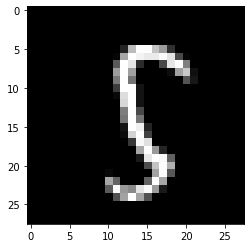

In [7]:
show_img(images, img_id)
print('Label:', labels[img_id].item())

## 生成器と識別器の定義

In [8]:
class Generator(nn.Module):
    def __init__(self, config):
        super(Generator, self).__init__()
        self.img_shape = config.img_shape
        self.latent_dim = config.latent_dim

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(config.latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(self.img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(len(z), *self.img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self, config):
        super(Discriminator, self).__init__()
        self.img_shape = config.img_shape
        
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(self.img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        validity = self.model(img_flat)
        return validity

動作確認

g_out shape: torch.Size([10000, 1, 28, 28])
d_out_fake shape: torch.Size([10000, 1])
d_out_real shape: torch.Size([10000, 1])
Timer: 0.125082
Timer: 0.697208


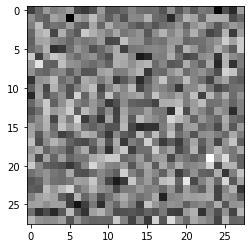

In [10]:
device = torch.device('cpu')

G = Generator(config)
D = Discriminator(config)

generator = iter(dataloader)
images, _ = generator.next()

z = torch.randn(config.batch_size, config.latent_dim).to(device)
g_out = G(z)
d_out_fake = D(g_out)
d_out_real = D(images)

print("g_out shape:", g_out.shape)
show_img(g_out, 0)

print("d_out_fake shape:", d_out_fake.shape)
# print("d_out_fake value:\n", d_out_fake.squeeze(-1))
print("d_out_real shape:", d_out_real.shape)
# print("d_out_real value:\n", d_out_real.squeeze(-1))

with Timer():
    d_out_real.mean().backward()

with Timer():
    g_out.mean().backward()

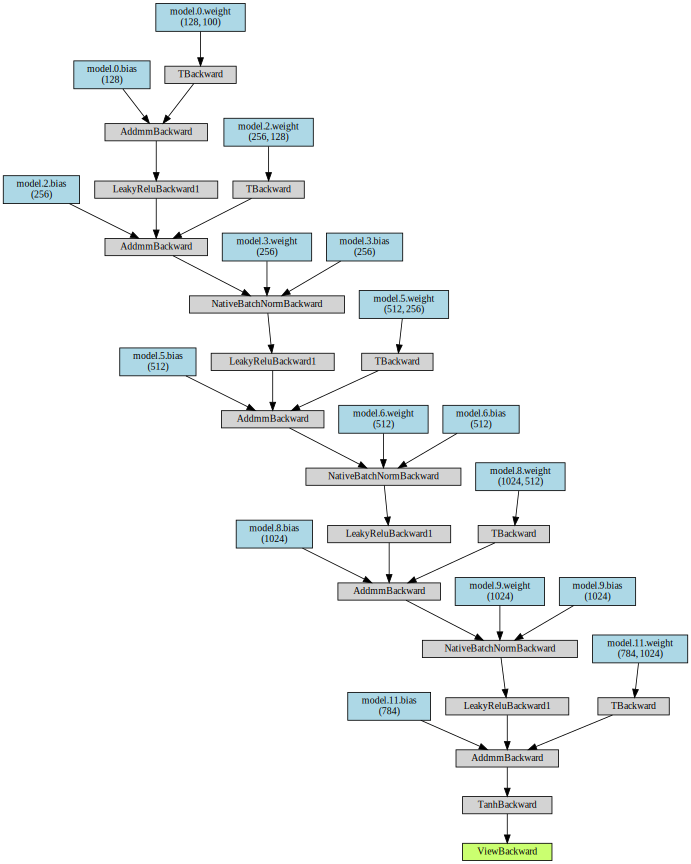

In [10]:
make_dot(g_out, params=dict(G.named_parameters()))

## モデルの準備
DataParallelにはなんかバグがあるらしいので注意  
https://github.com/pytorch/pytorch/issues/19024

In [10]:
device = torch.device('cuda')
multi_gpu = (len(visible_devices) > 1) & (device.type == 'cuda') & True

G = Generator(config).to(device)
D = Discriminator(config).to(device)

# Gの中でノイズ作って，DataParallel通すとGの出力のBatch数がGPUの個数倍になって出てくる謎現象が発生する
# zを外で作って先にdeviceを与えてやったらうまくいった
# てかmultigpuする必要もないほど軽い
if multi_gpu:
    print("Use Multi GPUs")
    G, D = MultiGPUWrapper(G), MultiGPUWrapper(D)

g_optim = optim.Adam(G.parameters(), lr=config.lr, betas=(config.b1, config.b2))
d_optim = optim.Adam(D.parameters(), lr=config.lr, betas=(config.b1, config.b2))

print("Network settings completed")
print("#parameters of G:", count_params(G))
print("#parameters of D:", count_params(D))

Network settings completed
#parameters of G: 1510032
#parameters of D: 533505


パラメータ数って意外とこんなもんなのね

## 学習関数の定義
研究用の実装からchordとかをなくす  
参考：https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/wgan_gp/wgan_gp.py

In [11]:
def calculate_gradient_penalty(D, real, fake, gp_lambda, device):
    
    # Random Weighted AverageによりRealとFakeの中間テンソルを取得
    eta = torch.empty(len(real), 1, 1, 1).uniform_(0, 1).to(device)
    interpolates = eta * real + ((1 - eta) * fake)
    interpolates = interpolates.requires_grad_(True)

    # 中間テンソルをDに通したテンソルを取得
    d_interpolates = D(interpolates)

    # 勾配計算の終端へ与える値？を作成
    grad_outputs = torch.ones((len(real), 1)).to(device)
    grad_outputs.requires_grad = False
    
    # 勾配ペナルティの計算に使用する勾配を取得
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=grad_outputs, 
        create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradients = gradients.view(len(gradients), -1)

    # 勾配ペナルティの計算
    grad_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * gp_lambda
    
    return grad_penalty



def train_wgan_gp(G, D, g_optim, d_optim, gtt, dtt, gp_lambda, dataloader, epoch_num, device,
              start_epoch=1, report_period=50, save_epoch_period=5, clear_disp_epoch_period=3, get_status_dict=True):
    
    torch.backends.cudnn.benchmark = True
    
    batch_num = len(dataloader)
    batch_size = dataloader.batch_size
    
    train_turn_table = np.zeros(gtt+dtt, dtype=bool)
    train_turn_table[:dtt] = True
    iteration = 0
    
    G.train()
    D.train()
        
    if get_status_dict:
        status_dict = { 'd_loss_real': [], 'd_loss_fake': [], 'wasserstein_d': [], 'g_loss': [] }

    try:
        total_d_loss_real = 0.0
        total_d_loss_fake = 0.0
        total_wasserstein_d = 0.0
        total_g_loss = 0.0
        
        for epoch in range(start_epoch, epoch_num+1):
            
            print(f"----- Epoch {epoch:>3} / {epoch_num:<3} start -----")
            t_epoch_start = time.time()
            t_iter_start = time.time()
            
            for batch_iteration, (batch, _) in enumerate(dataloader, 1):
                
                # WGANではバッチ数が計算に影響を与える?ため，バッチの切れ端は無視する
                if (len(batch) != batch_size):
                    continue
                
                real = batch
                
                # GもDもノイズは使うのでここで作成
                # 最初はGの中で作っていたが，MultiGPUにしたとき複数のGPUの結果をバッチにまとめて返してきたりする
                # それによるサイズ変化を防ぐため，外で作成して先にdeviceへ渡す
                z = torch.randn(batch_size, config.latent_dim).to(device)
                
                # Turn tableを回す
                turn = iteration % (gtt+dtt)
                iteration += 1
                
                ############
                # DのTurn
                ############
                if train_turn_table[turn]:
                    D.zero_grad()

                    real = real.to(device)

                    with torch.set_grad_enabled(True):
                        # realデータに対するLoss
                        d_loss_real = D(real)
                        d_loss_real = d_loss_real.mean()
                        total_d_loss_real += d_loss_real.item()

                        # fakeデータに対するLoss
                        fake = G(z)
                        d_loss_fake = D(fake)
                        d_loss_fake = d_loss_fake.mean()
                        total_d_loss_fake += d_loss_fake.item()

                        # 勾配ペナルティ
                        gradient_penalty = calculate_gradient_penalty(D, real, fake, gp_lambda, device)

                        # DのLoss全体，および Wasserstein距離を獲得
                        d_loss = d_loss_fake - d_loss_real + gradient_penalty
                        wasserstein_d = d_loss_real - d_loss_fake
                        total_wasserstein_d += wasserstein_d.item()

                        # Dのパラメータを更新
                        d_loss.backward()
                        d_optim.step()

                    if turn == dtt - 1:
                        # Turnの平均の記録
                        status_dict['d_loss_real'].append(total_d_loss_real / dtt)
                        status_dict['d_loss_fake'].append(total_d_loss_fake / dtt)
                        status_dict['wasserstein_d'].append(total_wasserstein_d / dtt)
                        total_d_loss_real = 0.0
                        total_d_loss_fake = 0.0
                        total_wasserstein_d = 0.0

                ############
                # GのTurn
                ############
                else:
                    G.zero_grad()

                    with torch.set_grad_enabled(True):
                        g_loss = D(G(z))
                        g_loss = - g_loss.mean()

                        total_g_loss += g_loss.item()

                        # Gのパラメータを更新
                        g_loss.backward()
                        g_optim.step()

                    if turn == (gtt + dtt) - 1:
                        # Turnの平均の記録
                        status_dict['g_loss'].append(total_g_loss / gtt)
                        total_g_loss = 0.0
                
                ####################
                # IterationのReport
                ####################
                if (iteration % report_period == 0):
                    duration = time.time() - t_iter_start
                    print(f"Iteration {batch_iteration:>5}/{batch_num:<5} | D real: {d_loss_real:.6f} | D fake: {d_loss_fake:.6f} | WD: {wasserstein_d:.6f} | G loss: {g_loss:.6f} | {duration:.4f} [sec]")
                    t_iter_start = time.time()


            ################
            # EpochのReport
            ################
            
            epoch_duration = time.time() - t_epoch_start
            print(f"Epoch {epoch:>3} / {epoch_num:<3} finished in {epoch_duration:.4f}[sec]")
            
            last_d_loss_real = status_dict['d_loss_real'][-1]
            last_d_loss_fake = status_dict['d_loss_fake'][-1]
            last_wasserstein_d = status_dict['wasserstein_d'][-1]
            last_g_loss = status_dict['g_loss'][-1]
            print(f"Epoch {epoch:>3} / {epoch_num:<3} Last Scores | D real: {last_d_loss_real:.6f} | D fake: {last_d_loss_fake:.6f} | WD: {last_wasserstein_d:.6f} | G loss: {last_g_loss:.6f}")
            
            remain_sec = epoch_duration * (epoch_num - epoch)
            print(f"Remaining Time | {remain_sec/3600:.4f} [hour] | {remain_sec/60:.2f} [min] | {remain_sec:.0f} [sec]\n")
            
            if epoch % clear_disp_epoch_period == 0:
                clear_output()

        print("All Training Finished!")
        
    except KeyboardInterrupt:
        print("Keyboard interrupted, but return models.")
        if get_status_dict:
            return G, D, status_dict
        return G, D
    
    if get_status_dict:
        return G, D, status_dict
    return G, D

## 学習の実行

In [12]:
epoch_num = 500
G_trained, D_trained, status_dict = train_wgan_gp(
    G=G, D=D,
    g_optim=g_optim, d_optim=d_optim,
    gtt=config.gtt, dtt=config.dtt,
    gp_lambda=config.gp_lambda,
    dataloader=dataloader,
    epoch_num=epoch_num,
    device=device,
    start_epoch=1,
    report_period=100000000,
    clear_disp_epoch_period=10
)

----- Epoch   1 / 500 start -----
Epoch   1 / 500 finished in 8.4100[sec]
Epoch   1 / 500 Last Scores | D real: 0.744549 | D fake: 0.014633 | WD: 0.729916 | G loss: -0.012574
Remaining Time | 1.1657 [hour] | 69.94 [min] | 4197 [sec]

----- Epoch   2 / 500 start -----
Epoch   2 / 500 finished in 7.9585[sec]
Epoch   2 / 500 Last Scores | D real: 4.109532 | D fake: 0.030067 | WD: 4.079466 | G loss: -0.039571
Remaining Time | 1.1009 [hour] | 66.06 [min] | 3963 [sec]

----- Epoch   3 / 500 start -----
Epoch   3 / 500 finished in 7.9694[sec]
Epoch   3 / 500 Last Scores | D real: 11.414307 | D fake: 0.097474 | WD: 11.316833 | G loss: -0.134156
Remaining Time | 1.1002 [hour] | 66.01 [min] | 3961 [sec]

----- Epoch   4 / 500 start -----
Keyboard interrupted, but return models.


ステータスグラフの確認

In [13]:
def show_status_graph_wgan_gp(status_dict, title="Score graphs of WGAN-gp"):
    d_loss_real = status_dict['d_loss_real']
    d_loss_fake = status_dict['d_loss_fake']
    wasserstein_d = status_dict['wasserstein_d']
    g_loss = status_dict['g_loss']
    
    fig, axs = plt.subplots(1, 3, figsize=(12, 6))
    
    x = np.arange(len(d_loss_real))
    axs[0].plot(x, d_loss_real, label='real', linewidth=1.5)
    axs[0].plot(x, d_loss_fake, label='fake', linewidth=1.5)
    axs[0].legend(loc='upper right')
    axs[0].set_xlabel('turn')
    axs[0].set_ylabel('loss')
    axs[0].set_title(f"D losses")

    axs[1].plot(x, wasserstein_d, label='wasserstein_d', linewidth=1.5)
    axs[1].legend(loc='upper right')
    axs[1].set_xlabel('turn')
    axs[1].set_ylabel('wasserstein_d')
    axs[1].set_title(f"Wasserstein distance")
    
    x = np.arange(len(g_loss))
    axs[2].plot(x, g_loss, label='loss', linewidth=1.5)
    axs[2].legend(loc='upper right')
    axs[2].set_xlabel('turn')
    axs[2].set_ylabel('loss')
    axs[2].set_title(f"G loss")

    plt.show()

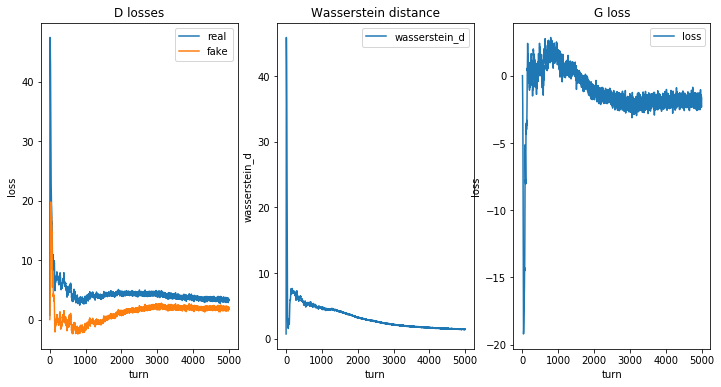

In [16]:
show_status_graph_wgan_gp(status_dict)

MultiGPUで200Epoch  
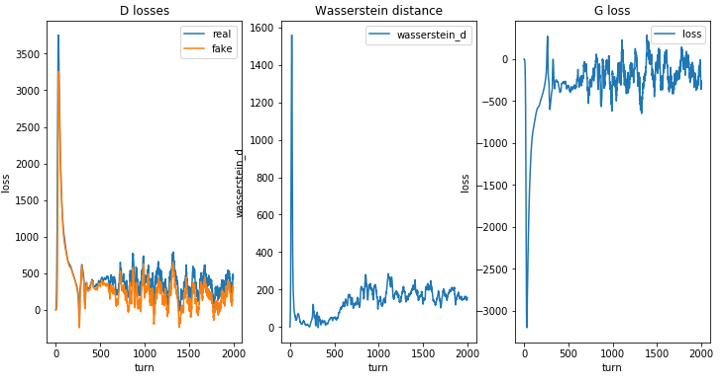

SingleGPUで200Epoch  
あんまり変わらんね  
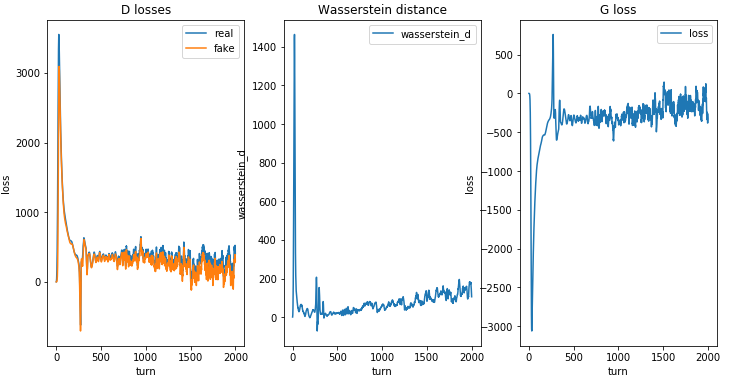

gradient penaltyのプログラム見直したらいい感じになった  
Wasserstein距離も機能してるっぽい  
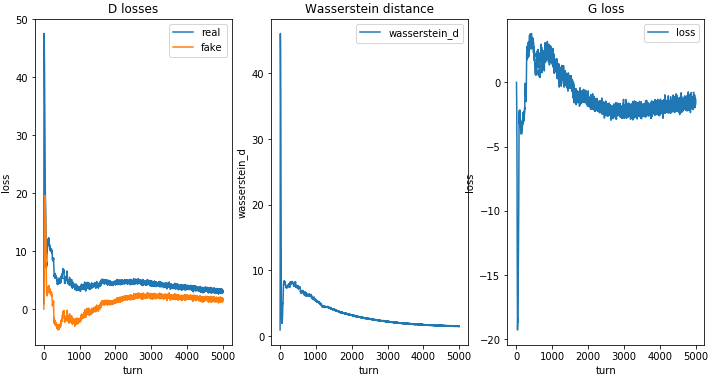

multiにしてやってみたもの  
あまり悪影響は出ていない模様  
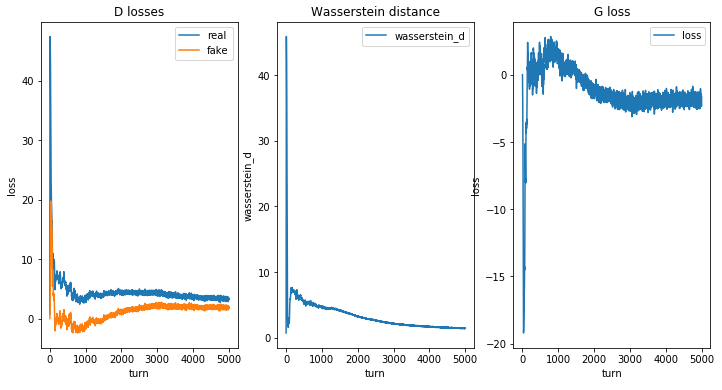

Adaptive WGAN-gpで500epoch  
不安定になるし収束しないしいいことない？  
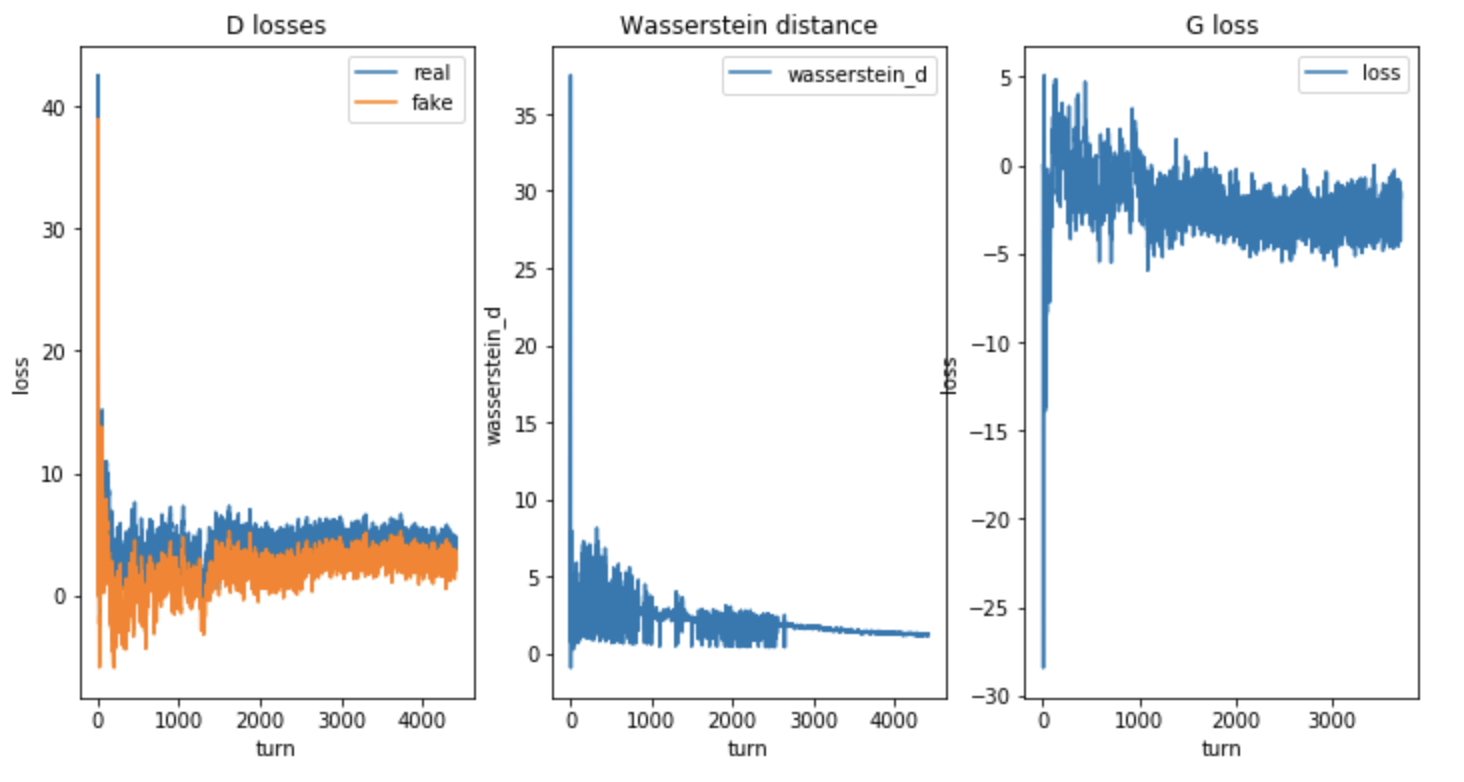

Adaptiveしていないもの  
最終的な値もこちらの方がよく，生成されている画像もより数字っぽい  
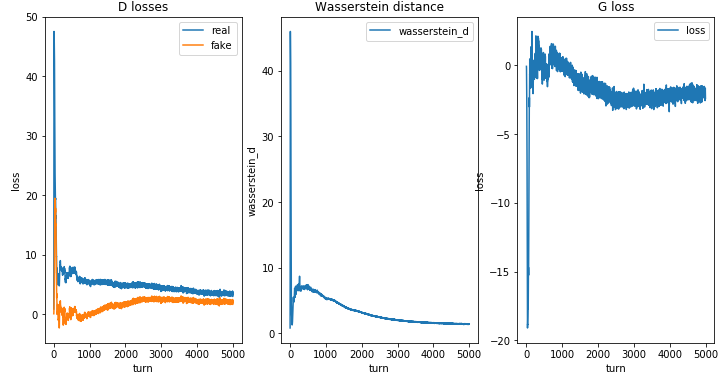

## 生成チェック

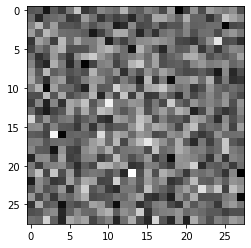

In [14]:
z = torch.randn(config.batch_size, config.latent_dim).to(device)
g_out = G(z)
show_img(g_out.cpu(), 0)

検証記録
- マルチGPU，Epoch 200：若干数字に見えるものもあるけどだいぶぐちゃってる  
- シングルでもあんまり変わらんかった  
- Epoch500は若干数字っぽくなってきた？  
- gradient penaltyのプログラム見直したら割とマシになった
- multiでも問題ない．これでいこう．

生成画像もまぁまぁいい感じ．ぼやけてるけど．  
しかしMNISTで500epochでこれだと結構時間かかりそうだなぁ

# MNISTによるAdaptive WGAN-gpのテスト

In [15]:
def calculate_gradient_penalty(D, real, fake, gp_lambda, device):
    
    # Random Weighted AverageによりRealとFakeの中間テンソルを取得
    eta = torch.empty(len(real), 1, 1, 1).uniform_(0, 1).to(device)
    interpolates = eta * real + ((1 - eta) * fake)
    interpolates = interpolates.requires_grad_(True)

    # 中間テンソルをDに通したテンソルを取得
    d_interpolates = D(interpolates)

    # 勾配計算の終端へ与える値？を作成
    grad_outputs = torch.ones((len(real), 1)).to(device)
    grad_outputs.requires_grad = False
    
    # 勾配ペナルティの計算に使用する勾配を取得
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=grad_outputs, 
        create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradients = gradients.view(len(gradients), -1)

    # 勾配ペナルティの計算
    grad_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * gp_lambda
    
    return grad_penalty



def train_adaptive_wgan_gp(G, D, g_optim, d_optim, gtt, dtt, adaptive, gp_lambda, dataloader, epoch_num, output_dir, device,
              start_epoch=1, report_period=50, clear_disp_epoch_period=3, save_epoch_period=None, get_status_dict=True):
    
    torch.backends.cudnn.benchmark = True
    
    batch_num = len(dataloader)
    batch_size = dataloader.batch_size
    
    current_dtt, current_gtt = dtt, gtt
    train_turn_table = np.zeros(dtt+gtt, dtype=bool)
    train_turn_table[:dtt] = True
    iteration = 0
    status_dict = { 'd_loss_real': [], 'd_loss_fake': [], 'wasserstein_d': [], 'g_loss': [] }
    
    G.train()
    D.train()

    try:
        total_d_loss_real = 0.0
        total_d_loss_fake = 0.0
        total_wasserstein_d = 0.0
        total_g_loss = 0.0
        
        for epoch in range(start_epoch, epoch_num+1):
            
            print(f"----- Epoch {epoch:>3} / {epoch_num:<3} start -----")
            t_epoch_start = time.time()
            t_iter_start = time.time()
            
            for batch_iteration, (batch, _) in enumerate(dataloader, 1):
                real = batch
                
                # GもDもノイズは使うのでここで作成
                # 最初はGの中で作っていたが，MultiGPUにしたとき複数のGPUの結果をバッチにまとめて返してきたりする
                # それによるサイズ変化を防ぐため，外で作成して先にdeviceへ渡す
                z = torch.randn(batch_size, config.latent_dim).to(device)
                
                # Turn tableを回す
                turn = iteration % (current_dtt+current_gtt)
                iteration += 1
                
                ############
                # DのTurn
                ############
                if train_turn_table[turn]:
                    D.zero_grad()
                    
                    real = real.to(device)
                                        
                    with torch.set_grad_enabled(True):
                        # realデータに対するLoss
                        d_loss_real = D(real)
                        d_loss_real = d_loss_real.mean()
                        total_d_loss_real += d_loss_real.item()

                        # fakeデータに対するLoss
                        fake = G(z)
                        d_loss_fake = D(fake)
                        d_loss_fake = d_loss_fake.mean()
                        total_d_loss_fake += d_loss_fake.item()
                        
                        # 勾配ペナルティ
                        gradient_penalty = calculate_gradient_penalty(D, real, fake, gp_lambda, device)

                        # DのLoss全体，および Wasserstein距離を獲得
                        d_loss = d_loss_fake - d_loss_real + gradient_penalty
                        wasserstein_d = d_loss_real - d_loss_fake
                        total_wasserstein_d += wasserstein_d.item()

                        # Dのパラメータを更新
                        d_loss.backward()
                        d_optim.step()
                    
                    if turn == current_dtt - 1:
                        # Turnの平均の記録
                        status_dict['d_loss_real'].append(total_d_loss_real / current_dtt)
                        status_dict['d_loss_fake'].append(total_d_loss_fake / current_dtt)
                        status_dict['wasserstein_d'].append(total_wasserstein_d / current_dtt)
                        total_d_loss_real = 0.0
                        total_d_loss_fake = 0.0
                        total_wasserstein_d = 0.0
                
                ############
                # GのTurn
                ############
                else:
                    G.zero_grad()

                    with torch.set_grad_enabled(True):
                        g_loss = D(G(z))
                        g_loss = - g_loss.mean()
                        
                        total_g_loss += g_loss.item()
                        
                        # Gのパラメータを更新
                        g_loss.backward()
                        g_optim.step()
                    
                    if turn == (current_gtt + current_dtt) - 1:
                        # Turnの平均の記録
                        status_dict['g_loss'].append(total_g_loss / current_gtt)
                        total_g_loss = 0.0
                
                
                #############################
                # Adaptive WGAN-gp
                # WDに応じてturn_tableを更新
                #############################
                if adaptive and len(status_dict['wasserstein_d']) > 0:
                    last_wd = status_dict['wasserstein_d'][-1]
                    current_dtt = int(dtt * max(1 - last_wd, 1))
                    current_gtt = int(gtt * max(1 + last_wd, 1))
                    train_turn_table = np.zeros(current_dtt + current_gtt, dtype=bool)
                    train_turn_table[:current_dtt] = True

                
                ####################
                # IterationのReport
                ####################
                if (iteration % report_period == 0):
                    duration = time.time() - t_iter_start
                    print(f"Iteration {batch_iteration:>4}/{batch_num:<4} | D real: {d_loss_real:.5f} | D fake: {d_loss_fake:.5f} | WD: {wasserstein_d:.5} | G loss: {g_loss:.5f} | dtt: {current_dtt} | gtt: {current_gtt} | {duration:.4f} [sec]")
                    t_iter_start = time.time()



            ################
            # EpochのReport
            ################
            
            epoch_duration = time.time() - t_epoch_start
            print(f"Epoch {epoch:>3} / {epoch_num:<3} finished in {epoch_duration:.4f}[sec]")
            
            last_d_loss_real = status_dict['d_loss_real'][-1]
            last_d_loss_fake = status_dict['d_loss_fake'][-1]
            last_wasserstein_d = status_dict['wasserstein_d'][-1]
            last_g_loss = status_dict['g_loss'][-1]
            print(f"Epoch {epoch:>3} / {epoch_num:<3} Last Scores | D real: {last_d_loss_real:.6f} | D fake: {last_d_loss_fake:.6f} | WD: {last_wasserstein_d:.6f} | G loss: {last_g_loss:.6f}")
            
            remain_sec = epoch_duration * (epoch_num - epoch)
            print(f"Remaining Time | {remain_sec/3600:.4f} [hour] | {remain_sec/60:.2f} [min] | {remain_sec:.0f} [sec]\n")
            
            if epoch % clear_disp_epoch_period == 0:
                clear_output()
            
            # チェックポイントモデルの保存
            if (save_epoch_period is not None) and (epoch % save_epoch_period == 0):
                print("start saving models")
                save_model(config, G, epoch, output_dir)
                save_model(config, D, epoch, output_dir)
                print("")

        print("All Fine-Tuning Finished!")
        
    except KeyboardInterrupt:
        print("Keyboard interrupted, but return models.")
        if get_status_dict:
            return G, D, status_dict
        return G, D
    
    if get_status_dict:
        return G, D, status_dict
    return G, D

## 学習の実行

In [ ]:
epoch_num = 500
G_trained, D_trained, status_dict = train_adaptive_wgan_gp(
    G=G, D=D,
    g_optim=g_optim, d_optim=d_optim,
    gtt=config.gtt, dtt=config.dtt,
    adaptive=False,
    gp_lambda=config.gp_lambda,
    dataloader=dataloader,
    output_dir="../datasets/mnist",
    epoch_num=epoch_num,
    device=device,
    start_epoch=1,
    report_period=100000000,
    clear_disp_epoch_period=10
)

----- Epoch  21 / 500 start -----
Epoch  21 / 500 finished in 7.9080[sec]
Epoch  21 / 500 Last Scores | D real: 38.940564 | D fake: 14.374552 | WD: 24.566012 | G loss: -14.075729
Remaining Time | 1.0522 [hour] | 63.13 [min] | 3788 [sec]

----- Epoch  22 / 500 start -----
Epoch  22 / 500 finished in 7.9195[sec]
Epoch  22 / 500 Last Scores | D real: 37.583144 | D fake: 15.675621 | WD: 21.907524 | G loss: -15.331509
Remaining Time | 1.0515 [hour] | 63.09 [min] | 3786 [sec]

----- Epoch  23 / 500 start -----


In [ ]:
show_status_graph_wgan_gp(status_dict)

## 生成チェック

In [ ]:
z = torch.randn(config.batch_size, config.latent_dim).to(device)
g_out = G(z)
show_img(g_out.cpu(), 0)